Creating first  model for wind generation prediction

* Get data
* Preprocessing
* Format data( test - train split)
* Build model
* Test model

In [1]:
# Load libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import models as mdl
import preprocessing as pre
import plot_creation as plt_data
import model_data_generation as dataGen
# create object to plot data
create_model = mdl.CreateModel()

#### Load data

In [2]:
DEMAND = 'Demand'
# path
path = "\Path_of_energy_data"
year = [ '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
month = ['01_Jan', '02_Feb', '03_Mar', '04_Apr', '05_May', '06_Jun', '07_Jul', '08_Aug', '09_Sep', '10_Oct', '11_Nov', '12_Dec']

# load data
df = pre.load_data(path, year, typ = DEMAND)


------------------------------------------------------------

Shape of the data:
(525696, 4)

------------------------------------------------------------
 First 5 rows: 

            DATE & TIME  ACTUAL DEMAND(MW)  FORECAST DEMAND(MW)      REGION
0  1 January 2014 00:00               3758                    -  All Island
1  1 January 2014 00:15               3724                    -  All Island
2  1 January 2014 00:30               3666                    -  All Island
3  1 January 2014 00:45               3611                    -  All Island
4  1 January 2014 01:00               3543                    -  All Island


#### Preprocessing

In [3]:
df_ire , df = pre.data_preprocess(df, typ=DEMAND)


------------------------------------------------------------
 Column Names:
Index(['DATE & TIME', ' ACTUAL DEMAND(MW)', ' FORECAST DEMAND(MW)', ' REGION'], dtype='object')

------------------------------------------------------------

 Dataset information:
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 525696 entries, 0 to 2879
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   DATE & TIME           525696 non-null  object        
 1    ACTUAL DEMAND(MW)    525530 non-null  object        
 2    FORECAST DEMAND(MW)  0 non-null       float64       
 3    REGION               525696 non-null  object        
 4   datetime              525696 non-null  datetime64[ns]
 5   year                  525696 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 28.1+ MB
None
------------

##### visualisation

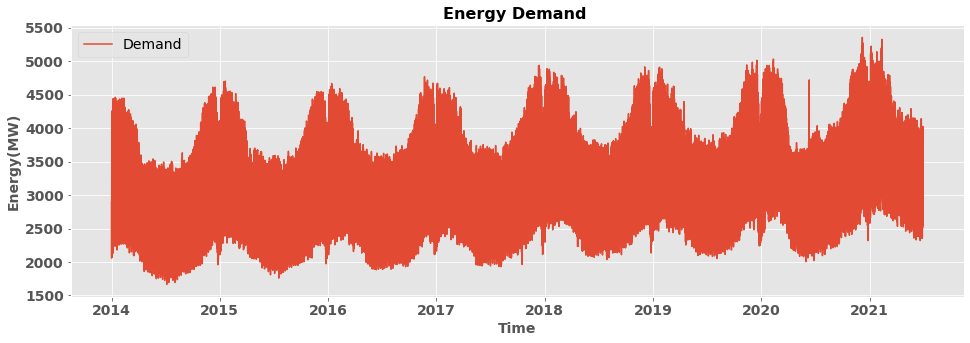

In [4]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=df_ire.index, values=df_ire[DEMAND],title='Energy Demand ', label='Demand')

In [5]:
weekly_ire = df.set_index('datetime').resample('1W').mean()['Demand']
weekly_ire = weekly_ire.dropna()
weekly_ire.head()

datetime
2014-01-05    3532.352083
2014-01-12    3787.046875
2014-01-19    3804.086310
2014-01-26    3801.238839
2014-02-02    3855.973214
Freq: W-SUN, Name: Demand, dtype: float64

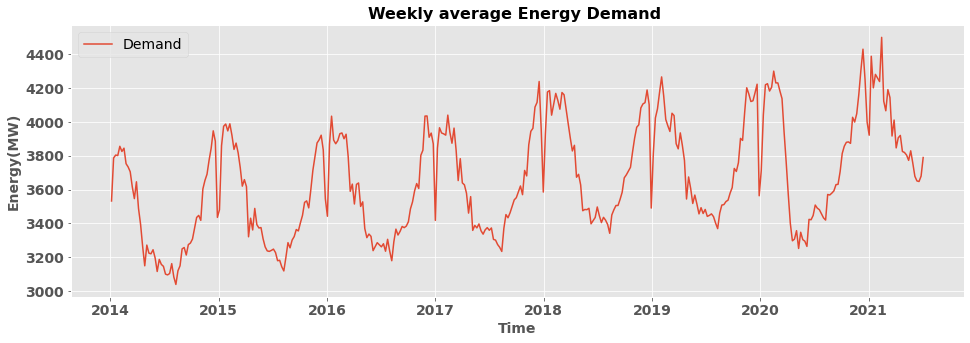

In [6]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=weekly_ire.index, values=weekly_ire,title='Weekly average Energy Demand ', label= 'Demand')

In [7]:
monthly_ire = df.set_index('datetime').resample('1M').mean()['Demand']
monthly_ire = monthly_ire.dropna()
monthly_ire.head()

datetime
2014-01-31    3783.536458
2014-02-28    3799.129092
2014-03-31    3614.153769
2014-04-30    3318.133507
2014-05-31    3231.331317
Freq: M, Name: Demand, dtype: float64

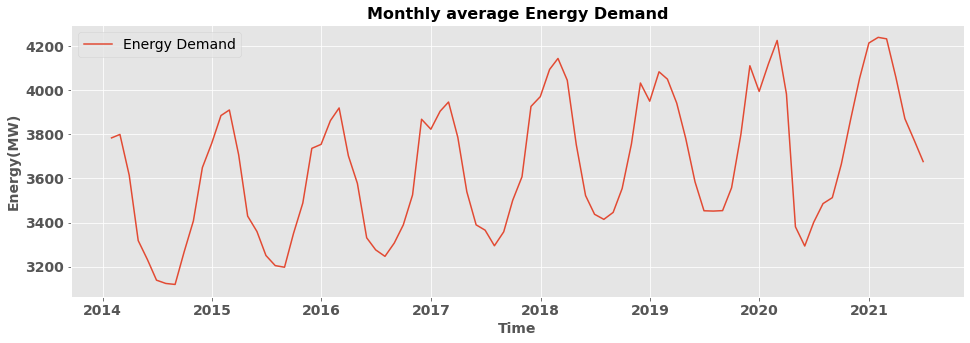

In [8]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=monthly_ire.index, values=monthly_ire,title='Monthly average Energy Demand', label= 'Energy Demand')

### RNN

In [9]:
HORIZON = 25 # 6 hours data
WINDOW_SIZE = 30 
model_name= 'rnn'
batch_size = 32
norm_method ="zscore"
test_split = 0.2
learning_rate = 0.001
max_steps_per_epoch = 10000
epochs = 5
model_args = {
            "layers": 1,
            "units": 64, 
            "return_sequence": False 
        }

#### Format data-  train test split

In [10]:
df_ire_model = df_ire[(df_ire.index.year != 2020) & (df_ire.index.year != 2021) & (df_ire.index.year != 2019)]

# data array - converting the dataframe to array 
timesteps , data_array = dataGen.df_to_array(df_ire_model = df_ire_model, typ = DEMAND)

# Data normalization based on the 'normalization method'
normalied_data_array, norm_scaler = dataGen.normalize_data( 
                                                    data = data_array,
                                                    method = norm_method
                                                )  

First-5 entry in data array :
------------------------------------------------------------
Timestamp:
 ['2014-01-01T00:00:00.000000000' '2014-01-01T00:15:00.000000000'
 '2014-01-01T00:30:00.000000000' '2014-01-01T00:45:00.000000000'
 '2014-01-01T01:00:00.000000000'] 
Energy Demand(MW):
 [2899. 2869. 2826. 2787. 2724.]


##### train test split

In [11]:
# Train-Test split 70-30
TRAIN_SIZE = 0.7

# 70% train, 30% test
split_size = int(TRAIN_SIZE * len(data_array)) 

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], data_array[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], data_array[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(122658, 52569, 122658, 52569)

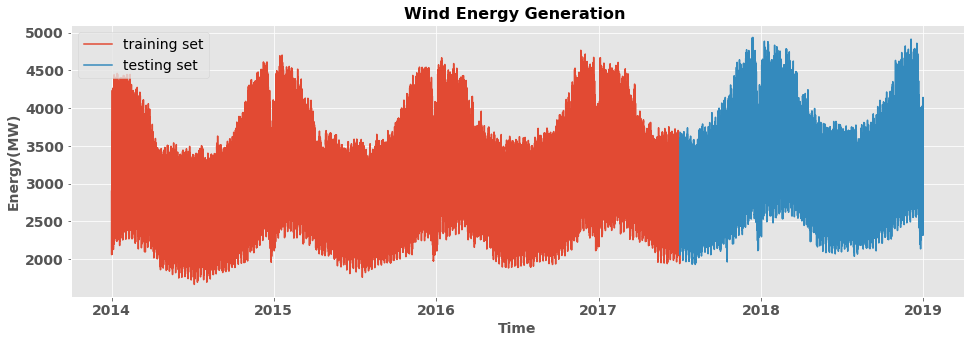

In [13]:
plt.figure(figsize=(16, 5))
plt_data.plot_time_series(timesteps=X_train, values=y_train ,title='Wind Energy Generation ', label= 'training set')
plt_data.plot_time_series(timesteps=X_test, values=y_test ,title='Wind Energy Generation ', label= 'testing set')

##### Windowing the dataset 

In [14]:
# get windows and labels from the data array
full_windows, full_labels = dataGen.make_windows(
                                            x = normalied_data_array, 
                                            window_size = WINDOW_SIZE, 
                                            horizon=HORIZON
                                        )

# train test split of windows and labels
train_windows, test_windows, train_labels, test_labels = dataGen.make_train_test_splits(
                                                                            windows = full_windows, 
                                                                            labels = full_labels, 
                                                                            test_split = test_split
                                                                        )


Window shape: (175173, 30) 
Label shape: (175173, 25)
Train Window shape: (140138, 30) 
Train Label shape: (140138, 25) 
Test Window shape: (35035, 30) 
Test Label shape: (35035, 25)


#### Build Model 

In [15]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")

for device in  gpu_devices :
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(device, "GPU") 

##### model definition

In [16]:
# Model definition
model_rnn = create_model.rnn(
            input_shape = WINDOW_SIZE,
            name = "%s_%s%s_%s_%s" %(DEMAND, model_name, batch_size, norm_method, test_split),
            output_size=HORIZON,
            optimizer= tf.optimizers.Adam(learning_rate=learning_rate),
            loss="mse",
            recurrent_units = [model_args["units"]] * model_args["layers"],
            return_sequences = model_args["return_sequence"]
        ) 

print('\nModel Summary:')
print(model_rnn.summary())


Model Summary:
Model: "Demand_rnn32_zscore_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 30)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                6080      
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
Total params: 7,705
Trainable params: 7,705
Non-trainable params: 0
_________________________________________________________________
None


##### Model training

In [17]:
print('\nModel Training:')

# Fit the model with 80 - 20 split
fit = create_model.fit_model(model_rnn, train_windows, train_labels, test_windows, test_labels, 
                            batch_size= batch_size, epochs=epochs, max_steps_per_epoch=max_steps_per_epoch, save_path= 'model_test_experiments')


Model Training:
INFO:tensorflow:Assets written to: model_test_experiments\Demand_rnn32_zscore_0.2\assets
INFO:tensorflow:Assets written to: model_test_experiments\Demand_rnn32_zscore_0.2\assets
INFO:tensorflow:Assets written to: model_test_experiments\Demand_rnn32_zscore_0.2\assets
INFO:tensorflow:Assets written to: model_test_experiments\Demand_rnn32_zscore_0.2\assets


##### plot traing performance

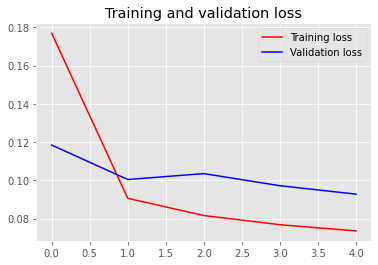

In [18]:
# plot in training performance
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Loas RNN

In [19]:
# Load in best version of model
model_rnn = tf.keras.models.load_model("model_test_experiments/Demand_rnn32_zscore_0.2/")

### LSTM

In [20]:
HORIZON = 25 # 6 hours data
WINDOW_SIZE = 30 
model_name= 'lstm'
batch_size = 32
norm_method ="zscore"
test_split = 0.2
learning_rate = 0.001
max_steps_per_epoch = 10000
epochs = 5
model_args = {
            "layers": 1,
            "units": 32, 
            "return_sequence": False 
        }

#### Format data-  train test split

In [21]:
df_ire_model = df_ire[(df_ire.index.year != 2020) & (df_ire.index.year != 2021) & (df_ire.index.year != 2019)]

# data array - converting the dataframe to array 
timesteps , data_array = dataGen.df_to_array(df_ire_model = df_ire_model, typ = DEMAND)

# Data normalization based on the 'normalization method'
normalied_data_array, norm_scaler = dataGen.normalize_data( 
                                                    data = data_array,
                                                    method = norm_method
                                                )    

First-5 entry in data array :
------------------------------------------------------------
Timestamp:
 ['2014-01-01T00:00:00.000000000' '2014-01-01T00:15:00.000000000'
 '2014-01-01T00:30:00.000000000' '2014-01-01T00:45:00.000000000'
 '2014-01-01T01:00:00.000000000'] 
Energy Demand(MW):
 [2899. 2869. 2826. 2787. 2724.]


##### Windowing the dataset 

In [22]:
 # get windows and labels from the data array
full_windows, full_labels = dataGen.make_windows(
                                            x = normalied_data_array, 
                                            window_size = WINDOW_SIZE, 
                                            horizon=HORIZON
                                        )

# train test split of windows and labels
train_windows, test_windows, train_labels, test_labels = dataGen.make_train_test_splits(
                                                                            windows = full_windows, 
                                                                            labels = full_labels, 
                                                                            test_split = test_split
                                                                        )


Window shape: (175173, 30) 
Label shape: (175173, 25)
Train Window shape: (140138, 30) 
Train Label shape: (140138, 25) 
Test Window shape: (35035, 30) 
Test Label shape: (35035, 25)


#### Build Model 

##### Model definition

In [23]:
# Model definition
model_lstm = create_model.lstm(
            input_shape = WINDOW_SIZE,
            name = "%s_%s%s_%s_%s" %(DEMAND, model_name, batch_size, norm_method, test_split),
            output_size=HORIZON,
            optimizer= tf.optimizers.Adam(learning_rate=learning_rate),
            loss="mse",
            recurrent_units = [model_args["units"]] * model_args["layers"],
            return_sequences = model_args["return_sequence"]
        ) 

print('\nModel Summary:')
print(model_lstm.summary())


Model Summary:
Model: "Demand_lstm32_zscore_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 30)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8064      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                825       
Total params: 8,889
Trainable params: 8,889
Non-trainable params: 0
_________________________________________________________________
None


##### model training

In [24]:
print('\nModel Training:')

# Fit the model with 80 - 20 split
fit = create_model.fit_model(model_lstm, train_windows, train_labels, test_windows, test_labels, 
                            batch_size= batch_size, epochs=epochs, max_steps_per_epoch=max_steps_per_epoch, save_path= 'model_test_experiments')


Model Training:


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


INFO:tensorflow:Assets written to: model_test_experiments\Demand_lstm32_zscore_0.2\assets


##### Plot traing performance

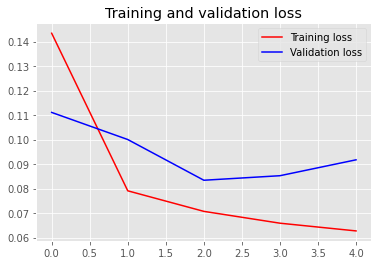

In [ ]:
# plot in training performance
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Load model

In [25]:
# Load in best version of model
model_lstm = tf.keras.models.load_model("model_test_experiments/Demand_lstm32_zscore_0.2/")

### Validation 

#### functions

In [26]:
def make_future_forecast(values, model, into_future=120, window_size=WINDOW_SIZE):
    """
    Makes future forecasts into_future steps after values ends.

    Returns future forecasts as list of floats.
    """
    # Empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:] # only want preds from the last window (this will be updated)

    # 3. Make INTO_FUTURE number of predictions, 
    for i in range(into_future):
    
        # Predict on last window then append it again
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))

        for j in future_pred.flatten():
            future_forecast.append(j)

        # Update last window with new pred and get WINDOW_SIZE most recent preds
        last_window = np.append(last_window, future_pred.flatten()[0])[-window_size:]
        # print(last_window)
  
    return future_forecast

def future_pred_values(model, data):
    """
    Funtion that returns future predictions based on the windowed 'data' and 'model'
    """
    # get prediction based on model
    preds = create_model.make_preds(model, data)
    preds = preds.numpy()

    future_pred = []
    for i in range(1, len(preds)+1) :

        if i == len(preds) :
            for e in preds[i-1:i].flatten():
                future_pred.append(e)
        else :
            future_pred.append(preds[i-1:i].flatten()[0])

    return future_pred

In [27]:
def monthly_prediction( 
    windows,
    model_rnn,
    model_lstm,
    scaler,
    actual,
    norm_data=np.array([]),
    length = 0
    ):
    """
    Function that makes monthly model predictions and returns evaluation results
    """
    # RNN Model prediction 
    if norm_data.any() :
        rnn_pred =  make_future_forecast(values=norm_data, model = model_rnn)[:length]  
    else :
        rnn_pred = future_pred_values( model = model_rnn, data = windows)

    # denormalize prediction
    rnn_pred = scaler.inverse_transform(rnn_pred)

    # LSTM Model prediction 
    if norm_data.any() :
        lstm_pred = make_future_forecast(values=norm_data, model = model_lstm)[:length]    
    else :
        lstm_pred = future_pred_values( model = model_lstm, data = windows)

    # denormalize prediction
    lstm_pred = scaler.inverse_transform(lstm_pred)


    # RNN model prediction evaluation 
    rnn_results = create_model.evaluate_preds(  y_true=actual, y_pred=rnn_pred)
    print('RNN Model prediction evaluation--')
    print(rnn_results)

    # LSTM model prediction evaluation 
    lstm_results = create_model.evaluate_preds(  y_true=actual, y_pred=lstm_pred)
    print('LSTM Model prediction evaluation--')
    print(lstm_results)

    return rnn_results, lstm_results , rnn_pred, lstm_pred 

#### MARCH

##### Prediction for the month of March-2019

In [28]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2019,
                                        prev_month = 2, # feb
                                        pred_month = 3, # mar
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
mar_windows, timesteps_mar, demand_mar, mar_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]



Window shape: (2948, 30) 
Label shape: (2948, 25)


In [29]:
# prediction evaluation for month of Mar - 2019
rnn_results_mar, lstm_results_mar, rnn_pred_mar, lstm_pred_mar = monthly_prediction( 
                                                                    windows= mar_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_mar
                                                                )

RNN Model prediction evaluation--
{'mae': 35.47078863993628, 'mse': 2602.5827052670847, 'rmse': 51.0155143585467}
LSTM Model prediction evaluation--
{'mae': 44.66134302644999, 'mse': 3753.588711335814, 'rmse': 61.26653826793068}


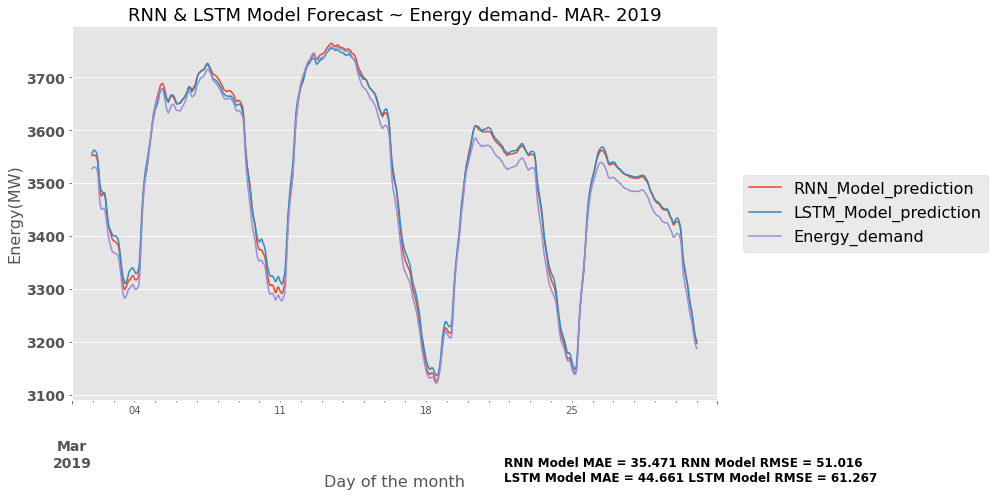

In [30]:
# plot predictions
d_mar = {   'datetime': timesteps_mar,
            'RNN_Model_prediction': rnn_pred_mar,
            'LSTM_Model_prediction': lstm_pred_mar,
            'Energy_demand' : demand_mar
        }       
df_mar = pd.DataFrame(data=d_mar)

df_mar_w_rolling = df_mar.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Demand- MAR- 2019
plt_data.plot_predictions( 
    df = df_mar_w_rolling,
    rnn_results = rnn_results_mar,
    lstm_results =  lstm_results_mar,
    title = "RNN & LSTM Model Forecast ~ Energy demand- MAR- 2019",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of March-2020

In [31]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2020,
                                        prev_month = 2, # feb
                                        pred_month = 3, # mar
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
mar_windows, timesteps_mar, demand_mar, mar_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2948, 30) 
Label shape: (2948, 25)


In [32]:
# prediction evaluation for month of Mar - 2020
rnn_results_mar, lstm_results_mar, rnn_pred_mar, lstm_pred_mar = monthly_prediction( 
                                                                    windows= mar_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_mar
                                                                )

RNN Model prediction evaluation--
{'mae': 36.7641940007781, 'mse': 2453.249810132974, 'rmse': 49.53029184380982}
LSTM Model prediction evaluation--
{'mae': 48.63059855855169, 'mse': 3946.7960532123716, 'rmse': 62.82353104699203}


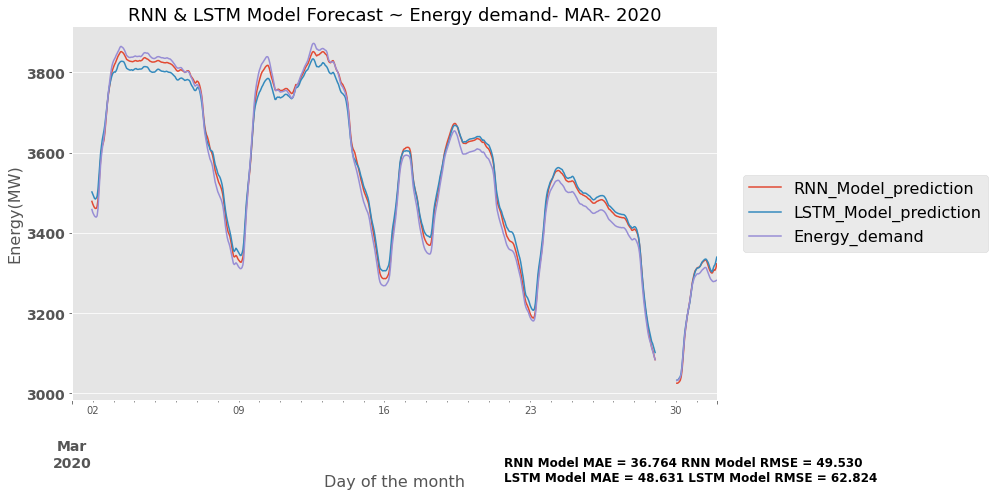

In [33]:
# plot predictions
d_mar = {   'datetime': timesteps_mar,
            'RNN_Model_prediction': rnn_pred_mar,
            'LSTM_Model_prediction': lstm_pred_mar,
            'Energy_demand' : demand_mar
        }       
df_mar = pd.DataFrame(data=d_mar)

df_mar_w_rolling = df_mar.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ EIR forecast ~ Wind Generation- MAR- 2020
plt_data.plot_predictions( 
    df = df_mar_w_rolling,
    rnn_results = rnn_results_mar,
    lstm_results =  lstm_results_mar,
    title = "RNN & LSTM Model Forecast ~ Energy demand- MAR- 2020",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of March-2021

In [56]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2021,
                                        prev_month = 2, # feb
                                        pred_month = 3, # mar
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
mar_windows, timesteps_mar, demand_mar, mar_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2948, 30) 
Label shape: (2948, 25)


In [57]:
#  prediction evaluation for month of Mar - 2021
rnn_results_mar, lstm_results_mar, rnn_pred_mar, lstm_pred_mar = monthly_prediction( 
                                                                    windows= mar_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_mar,
                                                                    norm_data = mar_norm_data,
                                                                    length = len(timesteps_mar)
                                                                )

RNN Model prediction evaluation--
{'mae': 656.8080161750557, 'mse': 664132.7297786974, 'rmse': 814.9433905362368}
LSTM Model prediction evaluation--
{'mae': 746.9130004225638, 'mse': 855095.1031228189, 'rmse': 924.7135248945042}


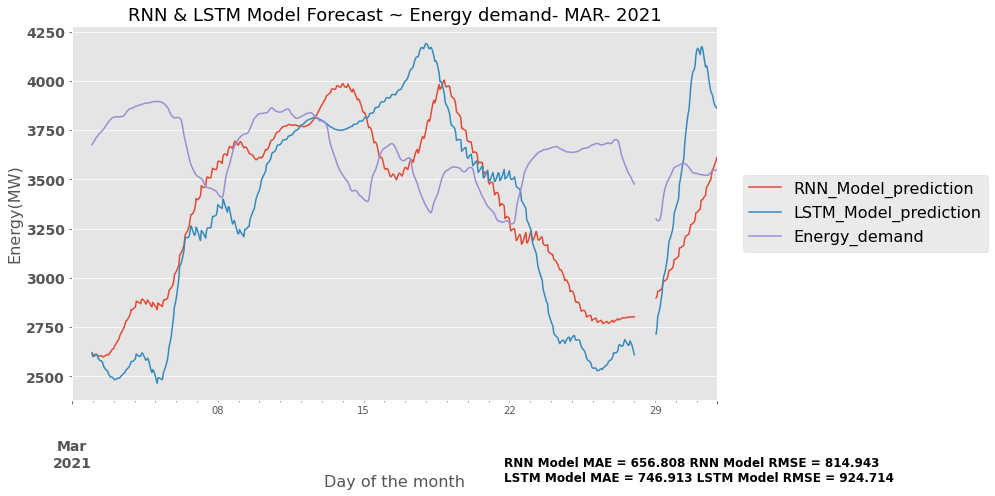

In [58]:
# plot predictions
d_mar = {   'datetime': timesteps_mar,
            'RNN_Model_prediction': rnn_pred_mar,
            'LSTM_Model_prediction': lstm_pred_mar,
            'Energy_demand' : demand_mar
        }       
df_mar = pd.DataFrame(data=d_mar)

df_mar_w_rolling = df_mar.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Demand- MAR- 2021
plt_data.plot_predictions( 
    df = df_mar_w_rolling,
    rnn_results = rnn_results_mar,
    lstm_results =  lstm_results_mar,
    title = "RNN & LSTM Model Forecast ~ Energy demand- MAR- 2021",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

#### APRIL

##### Prediction for the month of April-2019

In [37]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2019,
                                        prev_month = 3, # mar
                                        pred_month = 4, # apr
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
apr_windows, timesteps_apr, demand_apr, apr_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2856, 30) 
Label shape: (2856, 25)


In [38]:
# prediction evaluation for month of apr - 2019
rnn_results_apr, lstm_results_apr, rnn_pred_apr, lstm_pred_apr = monthly_prediction( 
                                                                    windows= apr_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_apr
                                                                )

RNN Model prediction evaluation--
{'mae': 39.3862296210395, 'mse': 3024.9163781261277, 'rmse': 54.99923979589288}
LSTM Model prediction evaluation--
{'mae': 44.06452848646376, 'mse': 3357.1220044384195, 'rmse': 57.940676596312024}


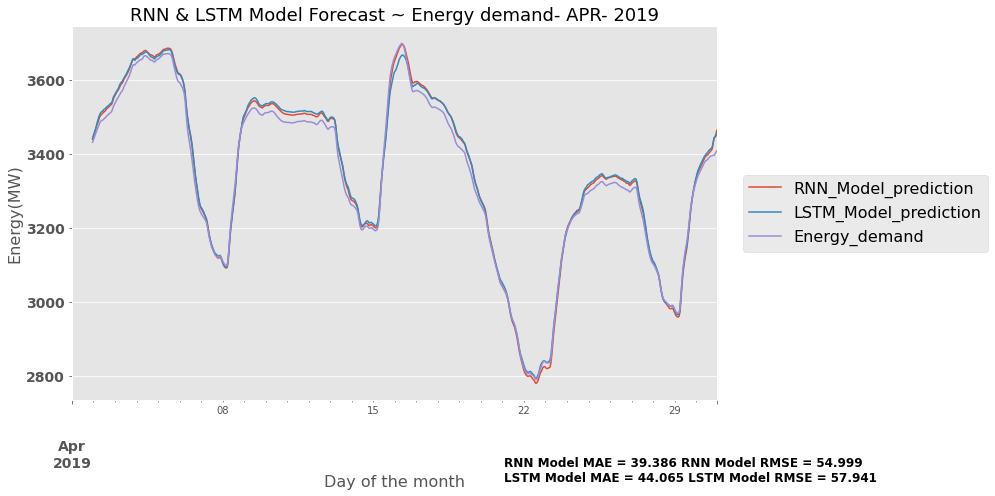

In [39]:
# plot predictions
d_apr = {   'datetime': timesteps_apr,
            'RNN_Model_prediction': rnn_pred_apr,
            'LSTM_Model_prediction': lstm_pred_apr,
            'Energy_demand' : demand_apr
        }       
df_apr = pd.DataFrame(data=d_apr)

df_apr_w_rolling = df_apr.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ demand - APR- 2019
plt_data.plot_predictions( 
    df = df_apr_w_rolling,
    rnn_results = rnn_results_apr,
    lstm_results =  lstm_results_apr,
    title = "RNN & LSTM Model Forecast ~ Energy demand- APR- 2019",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of April-2020

In [40]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2020,
                                        prev_month = 3, # mar
                                        pred_month = 4, # apr
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
apr_windows, timesteps_apr, demand_apr, apr_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2856, 30) 
Label shape: (2856, 25)


In [41]:
# prediction evaluation for month of apr - 2020
rnn_results_apr, lstm_results_apr, rnn_pred_apr, lstm_pred_apr = monthly_prediction( 
                                                                    windows= apr_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_apr,
                                                                    norm_data = apr_norm_data,
                                                                    length = len(timesteps_apr)
                                                                )

RNN Model prediction evaluation--
{'mae': 593.577589586046, 'mse': 543633.4888309931, 'rmse': 737.3150539837045}
LSTM Model prediction evaluation--
{'mae': 767.3275282753839, 'mse': 852268.684449833, 'rmse': 923.1839927391684}


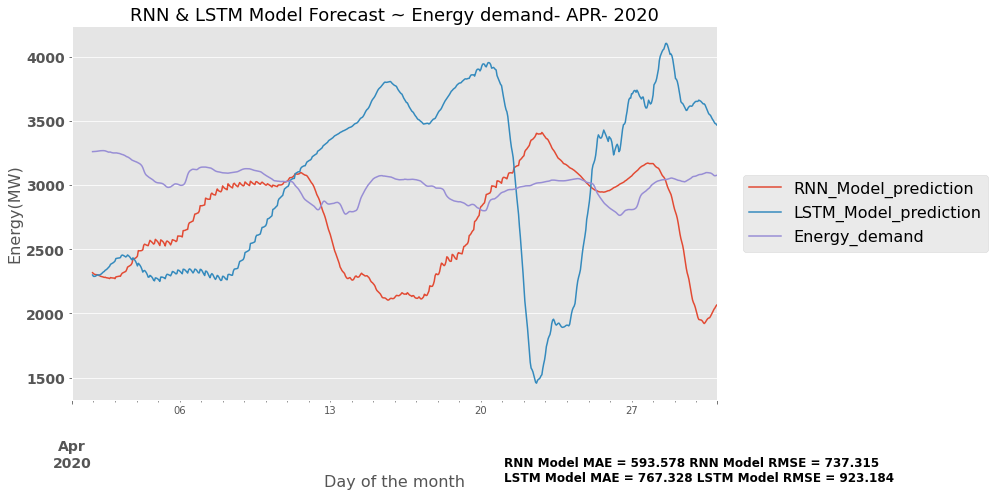

In [42]:
# plot predictions
d_apr = {   'datetime': timesteps_apr,
            'RNN_Model_prediction': rnn_pred_apr,
            'LSTM_Model_prediction': lstm_pred_apr,
            'Energy_demand' : demand_apr
        }       
df_apr = pd.DataFrame(data=d_apr)

df_apr_w_rolling = df_apr.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Energy demand- APR- 2020
plt_data.plot_predictions( 
    df = df_apr_w_rolling,
    rnn_results = rnn_results_apr,
    lstm_results =  lstm_results_apr,
    title = "RNN & LSTM Model Forecast ~ Energy demand- APR- 2020",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of April-2021

In [43]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2021,
                                        prev_month = 3, # mar
                                        pred_month = 4, # apr
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
apr_windows, timesteps_apr, demand_apr, apr_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2856, 30) 
Label shape: (2856, 25)


In [44]:
# prediction evaluation for month of apr - 2021
rnn_results_apr, lstm_results_apr, rnn_pred_apr, lstm_pred_apr = monthly_prediction( 
                                                                    windows= apr_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_apr,
                                                                    norm_data = apr_norm_data,
                                                                    length = len(timesteps_apr)
                                                                )

RNN Model prediction evaluation--
{'mae': 920.0441530015734, 'mse': 1181216.9218041701, 'rmse': 1086.8380384418692}
LSTM Model prediction evaluation--
{'mae': 769.6738139046563, 'mse': 962799.5495989429, 'rmse': 981.2234962529907}


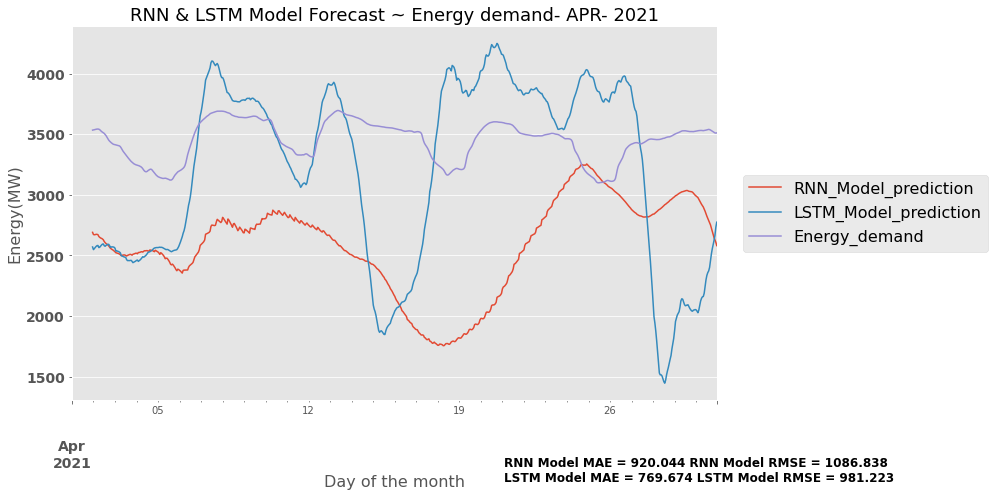

In [46]:
# plot predictions
d_apr = {   'datetime': timesteps_apr,
            'RNN_Model_prediction': rnn_pred_apr,
            'LSTM_Model_prediction': lstm_pred_apr,
            'Energy_demand' : demand_apr
        }       
df_apr = pd.DataFrame(data=d_apr)

df_apr_w_rolling = df_apr.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Energy demand- APR- 2021
plt_data.plot_predictions( 
    df = df_apr_w_rolling,
    rnn_results = rnn_results_apr,
    lstm_results =  lstm_results_apr,
    title = "RNN & LSTM Model Forecast ~ Energy demand- APR- 2021",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

#### MAY

##### Prediction for the month of May-2019

In [47]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2019,
                                        prev_month = 4, # apr
                                        pred_month = 5, # may
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
may_windows, timesteps_may, demand_may, may_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2952, 30) 
Label shape: (2952, 25)


In [48]:
# prediction evaluation for month of may - 2019
rnn_results_may, lstm_results_may, rnn_pred_may, lstm_pred_may = monthly_prediction( 
                                                                    windows= may_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_may
                                                                )

RNN Model prediction evaluation--
{'mae': 31.42630866266066, 'mse': 2457.547984934362, 'rmse': 49.57366221023379}
LSTM Model prediction evaluation--
{'mae': 36.337368380638864, 'mse': 2715.396058682593, 'rmse': 52.10946227589182}


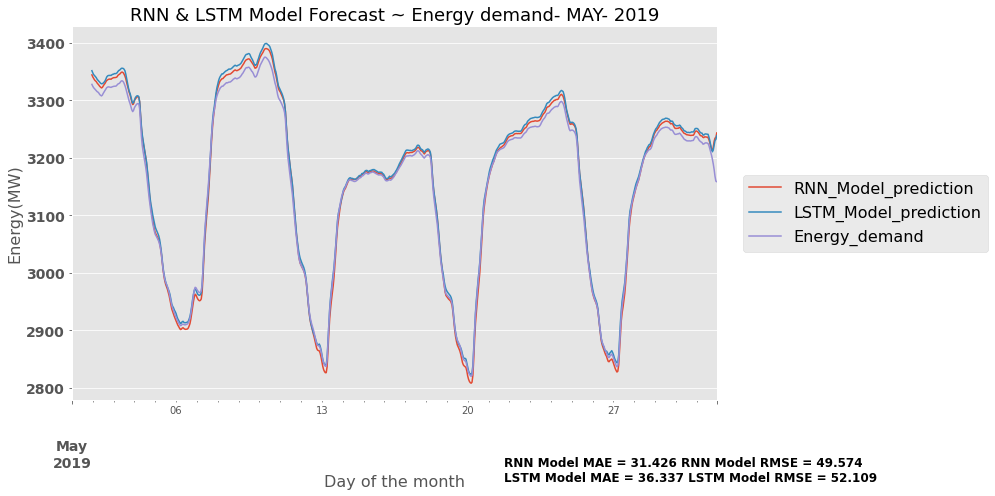

In [49]:
# plot predictions
d_may = {   'datetime': timesteps_may,
            'RNN_Model_prediction': rnn_pred_may,
            'LSTM_Model_prediction': lstm_pred_may,
            'Energy_demand' : demand_may
        }       
df_may = pd.DataFrame(data=d_may)

df_may_w_rolling = df_may.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Energy demand- MAY- 2019
plt_data.plot_predictions( 
    df = df_may_w_rolling,
    rnn_results = rnn_results_may,
    lstm_results =  lstm_results_may,
    title = "RNN & LSTM Model Forecast ~ Energy demand- MAY- 2019",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Prediction for the month of May-2020

In [50]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2020,
                                        prev_month = 4, # apr
                                        pred_month = 5, # may
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
may_windows, timesteps_may, demand_may, may_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2952, 30) 
Label shape: (2952, 25)


In [51]:
# prediction evaluation for month of may - 2020
rnn_results_may, lstm_results_may, rnn_pred_may, lstm_pred_may = monthly_prediction( 
                                                                    windows= may_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_may,
                                                                    norm_data = may_norm_data,
                                                                    length = len(timesteps_may)
                                                                )

RNN Model prediction evaluation--
{'mae': 593.3254765746414, 'mse': 535743.2568067434, 'rmse': 731.9448454677056}
LSTM Model prediction evaluation--
{'mae': 772.0918669136622, 'mse': 867173.6366078176, 'rmse': 931.2215829800218}


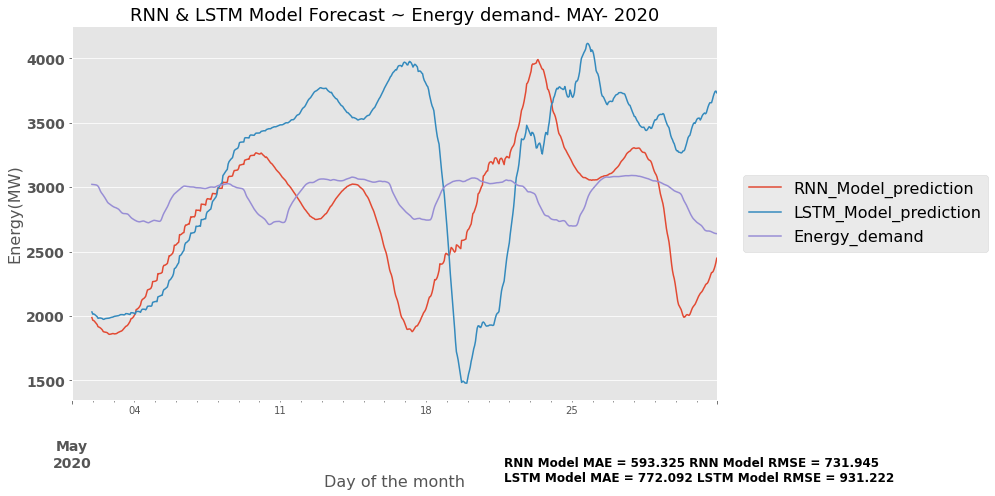

In [52]:
# plot predictions
d_may = {   'datetime': timesteps_may,
            'RNN_Model_prediction': rnn_pred_may,
            'LSTM_Model_prediction': lstm_pred_may,
            'Energy_demand' : demand_may
        }       
df_may = pd.DataFrame(data=d_may)

df_may_w_rolling = df_may.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Energy demand- MAY- 2020
plt_data.plot_predictions( 
    df = df_may_w_rolling,
    rnn_results = rnn_results_may,
    lstm_results =  lstm_results_may,
    title = "RNN & LSTM Model Forecast ~ Energy demand- MAY- 2020",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)

##### Precdiction for the month of May-2021

In [53]:
ret_list = dataGen.get_data_for_prediction(
                                        df_ire = df_ire,
                                        scaler = norm_scaler,
                                        year = 2021,
                                        prev_month = 4, # apr
                                        pred_month = 5, # may
                                        window_size =  WINDOW_SIZE,
                                        horizon =  HORIZON,
                                        typ = DEMAND
                                    )
may_windows, timesteps_may, demand_may, may_norm_data = ret_list[0], ret_list[1], ret_list[2], ret_list[3]


Window shape: (2952, 30) 
Label shape: (2952, 25)


In [54]:
# prediction evaluation for month of may - 2020
rnn_results_may, lstm_results_may, rnn_pred_may, lstm_pred_may = monthly_prediction( 
                                                                    windows= may_windows,
                                                                    model_rnn = model_rnn,
                                                                    model_lstm =  model_lstm,
                                                                    scaler = norm_scaler,
                                                                    actual = demand_may,
                                                                    norm_data = may_norm_data,
                                                                    length = len(timesteps_may)
                                                                )

RNN Model prediction evaluation--
{'mae': 827.4781235725649, 'mse': 960381.0214238862, 'rmse': 979.9903170051663}
LSTM Model prediction evaluation--
{'mae': 772.2502984487883, 'mse': 912510.673436228, 'rmse': 955.2542454426612}


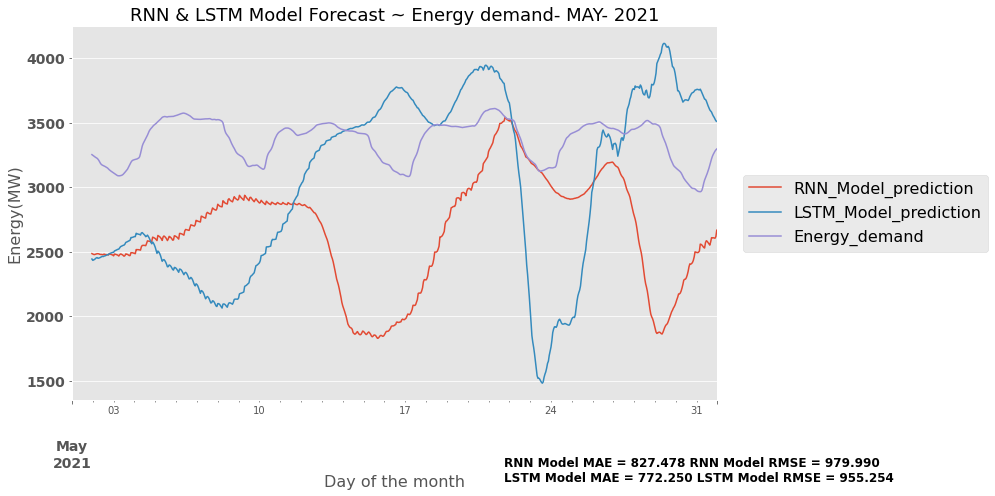

In [55]:
# plot predictions
d_may = {   'datetime': timesteps_may,
            'RNN_Model_prediction': rnn_pred_may,
            'LSTM_Model_prediction': lstm_pred_may,
            'Energy_demand' : demand_may
        }       
df_may = pd.DataFrame(data=d_may)

df_may_w_rolling = df_may.set_index('datetime').resample('1h').mean().rolling(window=24).mean() #- 24 hrs rolling avg

# Plot Model Forecast ~ Energy demand- MAY- 2021
plt_data.plot_predictions( 
    df = df_may_w_rolling,
    rnn_results = rnn_results_may,
    lstm_results =  lstm_results_may,
    title = "RNN & LSTM Model Forecast ~ Energy demand- MAY- 2021",
    figsize=(14, 7),
    anot_cord = (0.5, 0.03)
)